## How do we know if an object we see in the environment is stationary or moving?


Imagine you are driving a car. You see stationary objects (such as trees and buildings) as well as objects that can move independently  (such as other cars, people). In order to navigate around the objects, you need to know if the objects are stationary or moving in the world. 

However, our brain does not have direct information about the object. It only has access to visual signals - patterns of light projected on the retina. It can only infer if the object is stationary or moving from these visual cues. 

I propose that our brain implements a decision process, called causal inference, to determine if the object is stationary or moving independently in the world. Visual cues to the brain comprise of two motion signals: (1) The relative motion between our body and stationary objects , `xvis`; (2) The relative motion between our body and the object, `xobj`, which depends on both how the object moves in the world and how the observer moves in the world. Causal inference predicts if the object is stationary or not by evaluating the posterior probabilities associated with the two scenarios. 






## Bayesian model:

I develop a Bayesian model to forumalate the causal inference decision process. Here the observer compares the probability that object is stationary (C=1 scenario) with the probability that the object is moving (C=2 scenario). The model predicts the outcome consistent with the larger probability.

Let `xvis` respresent a noisy estimate of our self-motion vector. I assume that the noise in `xvis` is normally distrubited with mean =  $\mu$ and standard deviation = $\sigma_{vis}$. 

Let `xobj` represent the relative motion between our body and the object. Note that the way the object moves on the retina depends not only on the speed/direction of the object itself, but also on the speed/direction of our body movement. Thus, `xobj`, is a noisy estimate of the object with respect to the observer. I assume that the noise in `xobj` is normally distributed with mean $\mu$ and standard deviation $\sigma_{obj}$.

I also assume that the velocity of observer's self-motion (i.e., body motion) and object's velocity are drawn from Gaussian distributions with zero-mean and standard deviation of $\sigma_{p}$ and $\sigma_{o}$ respectively.

I simulate the model in a binary classification task where the observer views visual scene motion (optic flow, patterns of light on the retina simulating his/her movement) and motion of an object. The observer indicates if the object was stationary or moving in the world. 

The behavioral data for validating the model predictions has been published in the ** Proceedings of the National Academy of Sciences**. __[Article Link](https://www.pnas.org/content/116/18/9060.short?rss=1)__

Please also see Part 2 Notebook for an extension of this model. Each notebook is stand-alone and can be read by-itself.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

`bodymotion` refers to the observer's self-motion vector - it captures both the speed and the direction of observer's body movement. + indicates rightward motion and - indicates leftward motion.

In [2]:
# Defining the speed and direction of the observer's motion (i.e., self-motion).

body_angle = np.array([-45, 45] + list(range(-25,30,5)))

bodymotion = 13 * body_angle * (3.14/180)
bodymotion.sort()

`objmotion` refers to the velocity of object's motion in the world.  

In [3]:
# Defining the range of object velocities. 

objmotion = np.array([-200, -100, -50, -25, -10, -5, -2.5, 0, 2.5, 5, 10, 25, 50, 100, 200])

In [4]:
# Creating a matrix of self-motion and object speeds for easy matrix manipulation.

no_samples = 1000

[heading_orig, obj_orig] = np.meshgrid(bodymotion, objmotion)
heading_orig = heading_orig.reshape(heading_orig.shape[0],heading_orig.shape[1],1)
heading = np.repeat(heading_orig, no_samples, axis=2)

#### The model simulates the decision-making process for each cue sample. Each sample represents a single presentation of the self-motion and object motion stimuli. The model simulates 1000 such samples and computes the probabilities for each of the samples.

In [5]:
# Creating an array of 1000 samples for easy vector operations. 

obj_orig = obj_orig.reshape(obj_orig.shape[0],obj_orig.shape[1],1)
objvel = np.repeat(obj_orig, 1000, axis=2)

#### `heading` represents vectorized self-motion velocity (i.e., observer's).

In [6]:
# Simulating noisy visual self-motion samples.

sigma_vis = 5

xvis = heading + sigma_vis * np.random.normal(0,1,(heading.shape[0], heading.shape[1], heading.shape[2]))#

#### `objvel` represents vectorized object velocity in the world.


In [7]:
# Simulating noisy retinal object motion samples.

sigma_obj = 2

xobj = (objvel - heading) + sigma_obj * np.random.normal(0,1,(heading.shape[0],heading.shape[1],heading.shape[2]))

For the simulation purposes, I assume that self-motion stimuli (`bodymotion`) is drawn from a gaussian distribution with mean $\mu$=0 and standard deviation $\sigma_{p}$.

Similarly, I assume that object motion vector (`objmotion`) is drawn from a gaussian distribution with mean $\mu$ = 0 and standard deviation $\sigma_{o}$.

In [8]:
sigma_p = 5

sigma_o = 100

In [9]:
# For ease of mathematical operations, inverse variance is computed as J.

Jvis = 1/(sigma_vis**2)
Jobj = 1/(sigma_obj**2)
Jp   = 1/(sigma_p**2)
Jo   = 1/(sigma_o**2)
pcommon = 0.5

In [10]:
J4 = Jobj*Jo/(Jobj+Jo)

#### `pc1` is the likelihood that a stationary object underlies the observed `xvis` anx `xobj`.

In [11]:
pC1_constant = 1/(2*np.pi) * np.sqrt(   Jvis*Jobj*Jp/( (2*np.pi)*(Jvis+Jobj+Jp)    )   )

In [12]:
pC1_expterm = ( Jvis*Jobj*((xvis-xobj)**2) + Jp*Jobj*(xobj**2) + Jp*Jvis*(xvis**2) )/(Jvis+Jobj+Jp)

In [13]:
pC1 = pC1_constant * np.exp(-0.5 * pC1_expterm)

In [14]:
pC1_constant = 1/(2*np.pi) * np.sqrt(   Jvis*Jobj*Jp/( (2*np.pi)*(Jvis+Jobj+Jp)    )   )
pC1_expterm = ( Jvis*Jobj*((xvis-xobj)**2) + Jp*Jobj*(xobj**2) + Jp*Jvis*(xvis**2) )/(Jvis+Jobj+Jp)
pC1 = pC1_constant * np.exp(-0.5 * pC1_expterm)

#### `pc2` is the likelihood that an independently moving object is responsible for the observed `xvis` and `xobj`.

In [15]:
pC2_constant = 1/(2*np.pi) * np.sqrt(  (Jvis*Jp*J4) / (2*np.pi* (Jvis+Jp+J4) )  )

In [16]:
pC2_expterm = Jvis*Jp*(xvis**2) + Jp*J4*(xobj**2) + Jvis*J4*( (xvis-xobj)**2) / (Jvis+Jp+J4)

In [17]:
pC2 = pC2_constant * np.exp(-0.5 * pC2_expterm)

#### The model now calculates the ratio of the likelihoods `pc1/pc2`. `pcommon` is the prior probability of an object, in general, being stationary. `p_C1_C2` represents the ratio of the posterior probabilities of the C=1 (stationary object) to C=2 (moving object) scenarios.

In [18]:
pcommon = 0.8

p_C1_C2 = pC1*pcommon/(pC2*(1-pcommon))

#### The model predicts the object to be stationary if the ratio of likelihoods `p_C1_C2` > 1. 

In [19]:
bool_p_C1_C2 = p_C1_C2 > 1

#### Calculating the proportion of trials (or samples) for each object and self-motion velocity for which the model predicted a stationary object.

In [20]:
prop_OS = bool_p_C1_C2.sum(axis=2)/1000

In [22]:
# Converting model predictions into a dataframe.

propOS = pd.DataFrame(data=prop_OS, columns=list(np.sort(body_angle)))

propOS['object velocity'] = objmotion

propOS.set_index(keys='object velocity', inplace=True)



#### Calculating the proportion of object stationary reports for each object speed, averaged across all self-motion vectors.

In [23]:
model_pred = propOS.mean(axis=1)

#### Plotting the model's prediction verses the speed of the object. 

In [24]:
# Converting the object speed into a logarithmic axis for clear visualization.
xvar = np.nan_to_num(np.sign(model_pred.index)*np.log(np.abs(model_pred.index)))


C:\Users\D\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


Text(0.5, 1.0, 'Bayesian model predictions')

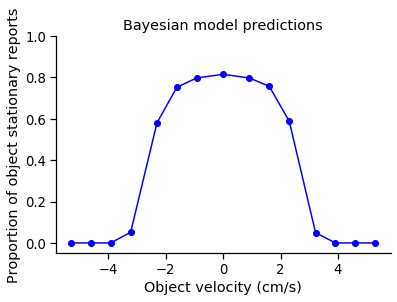

In [25]:
sns.set_style()
sns.set_context(context='notebook',font_scale = 1.2)
plt.plot(xvar, model_pred, marker='o',color='blue')
plt.ylim([-0.05,1])
sns.despine()
plt.ylabel("Proportion of object stationary reports")
plt.xlabel('Object velocity (cm/s)')
plt.title('Bayesian model predictions')

#### The Bayesian model predictions make intuitive sense. We are unlikely to mistake a fast moving object to be stationary - the model correctly predicts moving object in these trials. However, at slow speeds, we can be unsure of whether the object is moving at all. This is captured by ~ unity proportion of stationary object reports at slow speeds, and a decline in proportion reports as speed increases.

#### Thus, the Bayesian model explains well how the brain can determine the motion properties of an external object.

Now the observer estimates if the object is stationary or moving independently in the world. How does this information about whether the object is stationary or moving influence observer's perception of his/her movement.  Please see the accompanying notebook. 